DANSE algorithm Python implementation demonstrator

Paul Didier (KU Leuven, SOUNDS ETN) - 2022/2023

In [1]:
# Imports

import sys, os
import random
import numpy as np
import pyroomacoustics as pra
from pathlib import Path
import siggen.classes as sig_cl
import siggen.utils as sig_ut
import danse_toolbox.d_post as pp
from danse_toolbox.d_base import *
import danse_toolbox.d_core as core
#
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

# from siggen.classes import *
# from danse_toolbox.d_classes import *
# import danse_toolbox.d_post as pp
# import danse_toolbox.dataclass_methods as met


In [2]:
# Globals
SIGNALSPATH = f'{os.getcwd()}/testing/sigs'

Prepare acoustic environment and WASN

In [3]:
# Create WASN
wasnParams=sig_cl.WASNparameters(
    sigDur=4,
    rd=np.array([5, 5, 5]),
    fs=16000,
    t60=0.2,
    nNodes=2,
    # selfnoiseSNR=np.inf,  # if `== np.inf` --> no self-noise at all
    selfnoiseSNR=99,
    nSensorPerNode=[1, 3],
    desiredSignalFile=[f'{SIGNALSPATH}/01_speech/{file}'\
        for file in [
            'speech1.wav',
            'speech2.wav'
        ]],
    noiseSignalFile=[f'{SIGNALSPATH}/02_noise/{file}'\
        for file in [
            'whitenoise_signal_1.wav',
            'whitenoise_signal_2.wav'
        ]],
    SROperNode=np.array([0, 50])
    # SROperNode=np.array([0, 0])
)

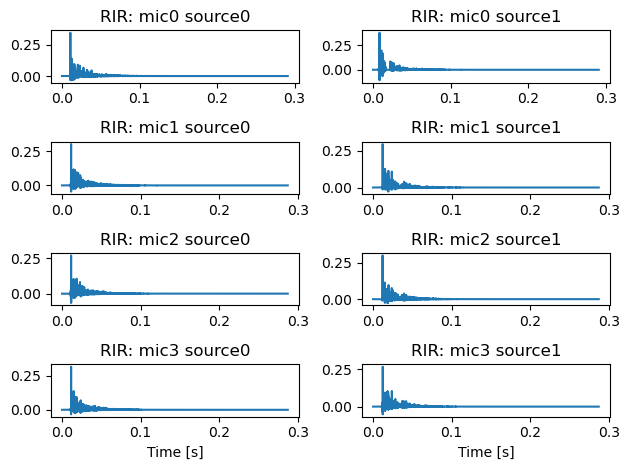

In [4]:
# Build room
room, vad, wetSpeechAtRefSensor = sig_ut.build_room(wasnParams)
# Show RIRs
room.plot_rir()
# Build WASN (asynchronicities, topology)
wasn = sig_ut.build_wasn(room, vad, wetSpeechAtRefSensor, wasnParams)

Run DANSE

In [5]:
# Set parameters
danseParams=DANSEparameters(
    DFTsize=1024,
    WOLAovlp=.5,
    # nodeUpdating='seq',
    nodeUpdating='asy',
    # broadcastType='fewSamples',
    broadcastType='wholeChunk',
    # estimateSROs='CohDrift',
    estimateSROs='DXCPPhaT',
    # compensateSROs=True,
    compensateSROs=True,
    cohDrift=CohDriftParameters(
        loop='open',
        alpha=0.99
    ),
    computeCentralised=True,
    computeLocal=True,
)
danseParams.get_wasn_info(wasnParams)  # complete parameters

In [6]:
# Run DANSE
for k in range(wasnParams.nNodes):  # for each node
    # Derive exponential averaging factor for `Ryy` and `Rnn` updates
    wasn[k].beta = np.exp(np.log(0.5) / \
        (danseParams.t_expAvg50p * wasn[k].fs / danseParams.Ns))

# Launch DANSE
out, wasnUpdated = core.danse(wasn, danseParams)

t=0.064s -- Broadcasting nodes: 2; Updating nodes: [b- @ t=0.064s] Buffer underflow at current node`s B_1 buffer | -1 broadcast
t=1.024s -- Broadcasting nodes: 2; Updating nodes: 2t=1.024s -- UPDATING EXTERNAL FILTERS for node 2 (scheduled every [at least] 1.0s)
t=1.024s -- Broadcasting nodes: 1; Updating nodes: 1t=1.024s -- UPDATING EXTERNAL FILTERS for node 1 (scheduled every [at least] 1.0s)
t=2.048s -- Broadcasting nodes: 2; Updating nodes: 2t=2.048s -- UPDATING EXTERNAL FILTERS for node 2 (scheduled every [at least] 1.0s)
t=2.048s -- Broadcasting nodes: 1; Updating nodes: 1t=2.048s -- UPDATING EXTERNAL FILTERS for node 1 (scheduled every [at least] 1.0s)
t=3.072s -- Broadcasting nodes: 2; Updating nodes: 2t=3.072s -- UPDATING EXTERNAL FILTERS for node 2 (scheduled every [at least] 1.0s)
t=3.072s -- Broadcasting nodes: 1; Updating nodes: 1t=3.072s -- UPDATING EXTERNAL FILTERS for node 1 (scheduled every [at least] 1.0s)
t=3.936s -- Broadcasting nodes: 1; Updating nodes: 1
Simultane

Show results

Node 1: computing speech enhancement metrics from the 12289'th sample on (t_start = 0.768 s --> avoid bias due to initial filters guesses in first iterations)...
Computing signal enhancement evaluation metrics for node 1/2 (sensor 1/1)...
Node 1: computing speech enhancement metrics for CENTRALISED PROCESSING from the 13313'th sample on (t_start = 0.832 s).
Node 1: computing speech enhancement metrics for LOCAL PROCESSING from the 11777'th sample on (t_start = 0.736 s).
Node 2: computing speech enhancement metrics from the 13825'th sample on (t_start = 0.8639568561544957 s --> avoid bias due to initial filters guesses in first iterations)...
Computing signal enhancement evaluation metrics for node 2/2 (sensor 1/3)...
Node 2: computing speech enhancement metrics for CENTRALISED PROCESSING from the 13825'th sample on (t_start = 0.8639568561544957 s).
Node 2: computing speech enhancement metrics for LOCAL PROCESSING from the 12801'th sample on (t_start = 0.7999600519949035 s).
Cannot calc

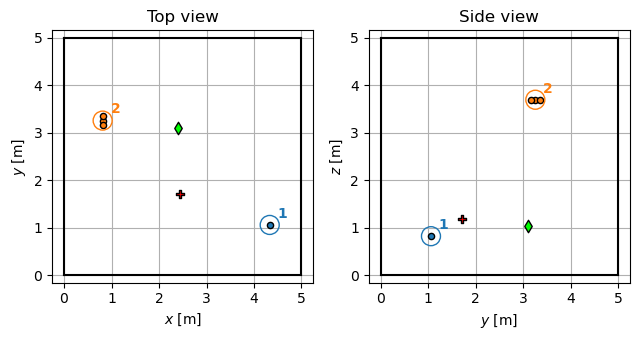

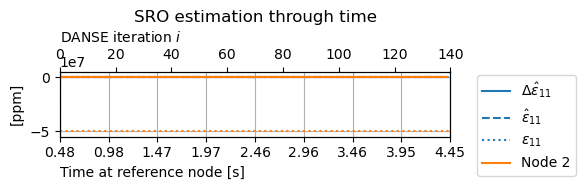

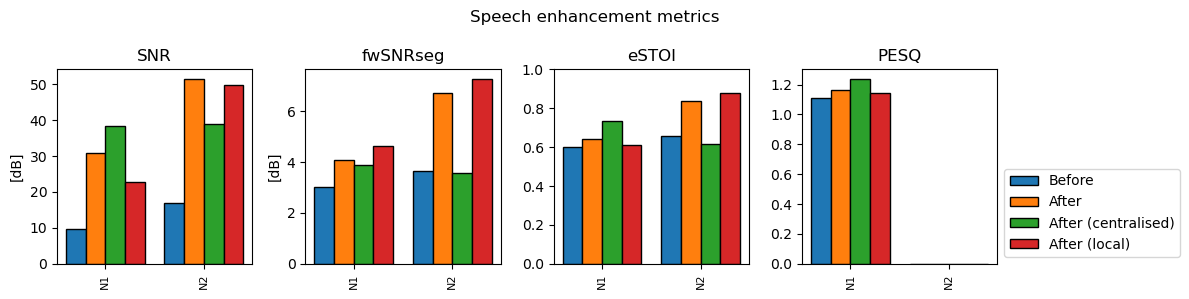

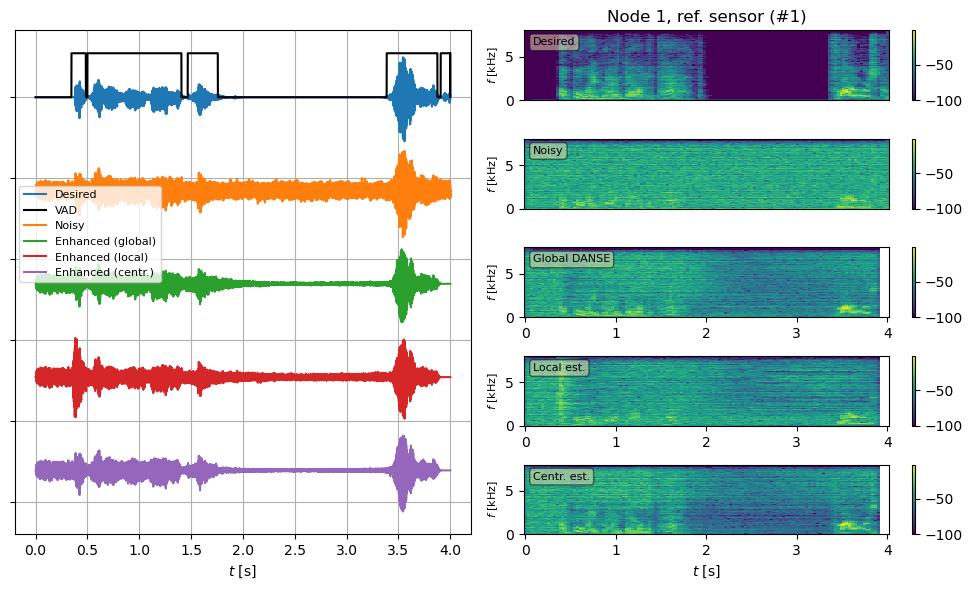

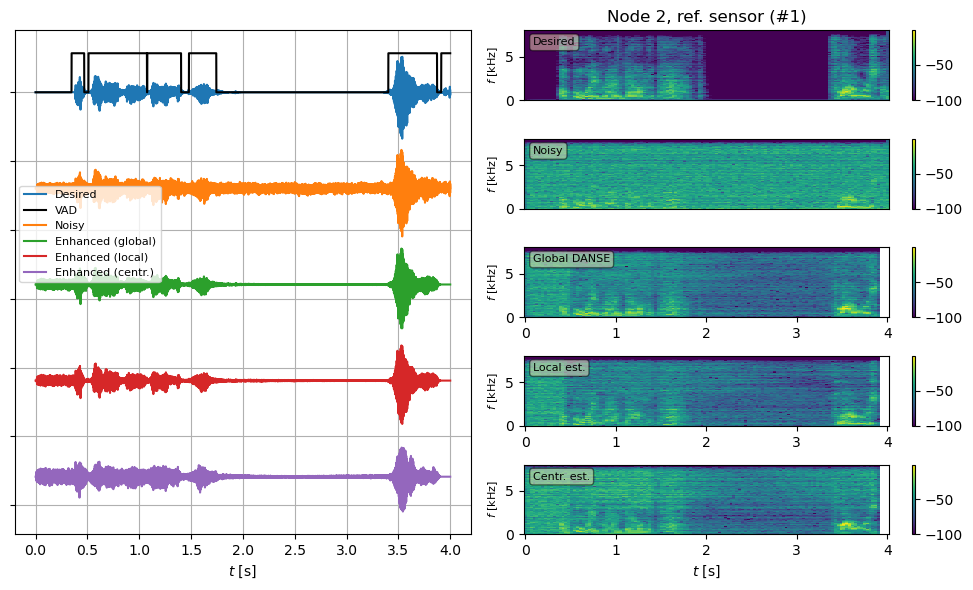

In [7]:

# Plot (do not export) acoustic scenario (WASN)
pp.plot_asc(room, wasnParams, folder=None)

# Plot SRO estimation performance
out.plot_sro_perf(
    Ns=danseParams.Ns,
    fs=wasnParams.fs,
    xaxistype='both'  # "both" == iterations [-] _and_ instants [s]
)

# Plot performance metrics (+ export)
out.plot_perf(wasn, exportFolder=None)

# Plot signals at specific nodes (+ export)
out.plot_sigs(wasn, exportFolder=None)

In [8]:
out.compensateSROs

True